In [2]:
import dgl
import torch
from dgl.data import DGLDataset
from datetime import date, timedelta
import os
from dgl import save_graphs, load_graphs
from dgl.data.utils import makedirs, save_info, load_info

class MyDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="my_dataset")

    def process(self):
        graphs = []

        start_date = date(2016, 1, 1)
        end_date = date(2016, 12, 31)
        delta = timedelta(days=1)
        while start_date <= end_date:
            # 根据日期生成文件名
            file_name = "2016/graph" + start_date.strftime("%Y%m%d") + ".dgl"
            (g,), _ = dgl.load_graphs(file_name)
            graphs.append(g)
            start_date += delta

        self.graphs = graphs
    def __getitem__(self, i):
        # 返回第i个图
        return self.graphs[i]

    def __len__(self):
        # 返回图的数量
        return len(self.graphs)

    def save(self):
        graph_path = os.path.join(self.save_path, 'dgl_graph.bin')
        save_graphs(str(graph_path), self.graphs)

    def has_cache(self):
        graph_path = os.path.join(self.save_path, 'dgl_graph.bin')
        return os.path.exists(graph_path)

    def load(self):
        graphs, label_dict = load_graphs(os.path.join(self.save_path, 'dgl_graph.bin'))
        self.graphs = graphs

In [109]:
import dgl
import torch
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')
    
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h


In [4]:
def evaluate(dataloader, device, model):
    model.eval()
    total_loss = 0
    total_n = 0
    for bg in dataloader:
        with torch.no_grad():
            bg=bg.to(device)
            feats = bg.ndata['feat']
            labels = bg.ndata['label']
            #pred = model(bg, )
            #print(feats)
            #print(labels)
            pred = model(bg, feats)
            loss = F.mse_loss(pred, labels)
            n = bg.ndata['feat'].shape[0]
            total_loss +=n*loss.item()
            total_n += n
    total_loss /=total_n
    return total_loss
    

In [5]:
# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('使用设备:', device)

使用设备: cuda


In [6]:
# 创建数据集
dataset = MyDataset()
# 打印数据集的信息
print(dataset)

Dataset("my_dataset", num_graphs=366, save_path=C:\Users\22929\.dgl\my_dataset)


In [7]:
dataset

Dataset("my_dataset", num_graphs=366, save_path=C:\Users\22929\.dgl\my_dataset)

In [8]:
from dgl.data.utils import split_dataset
# 加载你的数据集
dataset = MyDataset()
# 划分数据集，比例为[0.8, 0.1, 0.1]，即前80%为训练集，后10%为测试集，再后10%为验证集
# 设置随机种子为2023，保证每次划分的结果一致
train_set, test_set, val_set = split_dataset(dataset, frac_list=[0.8, 0.1, 0.1], shuffle=True, random_state=2023)


In [9]:
train_set[291]

Graph(num_nodes=9821, num_edges=56126,
      ndata_schemes={'O_WSPD': Scheme(shape=(1,), dtype=torch.float32), 'CRS_DEP_TIME': Scheme(shape=(1,), dtype=torch.float32), 'DEP_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'CRS_ARR_TIME': Scheme(shape=(1,), dtype=torch.float32), 'WHEELS_OFF': Scheme(shape=(1,), dtype=torch.float32), 'O_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'ARR_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'DEST': Scheme(shape=(1,), dtype=torch.float32), 'ORIGIN': Scheme(shape=(1,), dtype=torch.float32), 'O_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'DISTANCE': Scheme(shape=(1,), dtype=torch.float32), 'O_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'O_PRCP': Scheme(shape=(1,), dtype=torch.float32), 'D_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'D_PRCP': Scheme(shape=(1,), dtype=torch.float32), 'feat': Scheme(shape=(15,), dtype

In [10]:
print(train_set)

In [11]:
from dgl.dataloading import GraphDataLoader
train_dataloader = GraphDataLoader(train_set, batch_size=20, shuffle=True, num_workers=0)
test_dataloader = GraphDataLoader(test_set, batch_size=20, shuffle=True, num_workers=0)
val_dataloader = GraphDataLoader(val_set, batch_size=20, shuffle=True, num_workers=0)


In [12]:
train_set[0].ndata['feat'].shape[1]

15

In [13]:
train_set[0].ndata['feat'].shape[0]

11276

In [14]:
from dgl.dataloading import GraphDataLoader
train_dataloader = GraphDataLoader(train_set, batch_size=20, shuffle=True, num_workers=0)
test_dataloader = GraphDataLoader(test_set, batch_size=20, shuffle=True, num_workers=0)
val_dataloader = GraphDataLoader(val_set, batch_size=20, shuffle=True, num_workers=0)





In [108]:

import time 
start_time = time.perf_counter() 

loss_list = []
loss_test_list = []


# 输入特征维度
n_features = train_set[0].ndata['feat'].shape[1]

# 实例化一个SAGE模型
model = SAGE(in_feats=n_features, hid_feats=300, out_feats=1)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01) 



for epoch in range(10):
    model.train()
    total_loss = 0
    total_n = 0
    for bg in train_dataloader:
        bg = bg.to(device)
        #pred = model(g, )
        #print(bg)
        feats = bg.ndata['feat']
        labels = bg.ndata['label']
        #pred = model(bg, )
        #print(feats)
        #print(labels)
        
        pred = model(bg, feats)
        loss = F.mse_loss(pred, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        #print(loss.item())
        n = bg.ndata['feat'].shape[0]
        total_loss +=n*loss.item()
        total_n += n
    total_loss /=total_n 
    train_loss = evaluate(train_dataloader, device, model)
    valid_loss = evaluate(val_dataloader, device, model)
    loss_list.append(total_loss)
    loss_test_list.append(train_loss)
    print(
        "Epoch {:05d} | Loss {:.4f} | Train Acc. {:.4f} | Validation Acc. {:.4f} ".format(
            epoch, total_loss , train_loss, valid_loss
        )
    )
    
    
    
    #print(total_n)    
    #print(f"epoch={epoch}")  
    #print(f"total_loss={total_loss}")    
        
    '''
    train_pred = model(train_g, train_features)
    train_loss = F.mse_loss(train_pred, train_labels)
    valid_pred = model(valid_g, valid_features)
    valid_loss = F.mse_loss(valid_pred, valid_labels)
    test_pred = model(test_g, test_features)
    test_loss = F.mse_loss(test_pred, test_labels)
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    # 将损失值添加到列表中
    loss_list.append(train_loss.item())
    loss_test_list.append(test_loss.item())
    '''

end_time = time.perf_counter() 
elapsed_time = end_time - start_time 
print(f"Training took {elapsed_time} seconds.") 

Epoch 00000 | Loss 52369.3245 | Train Acc. 22558.0971 | Validation Acc. 24214.7330 
Epoch 00001 | Loss 7748.7211 | Train Acc. 1856.3493 | Validation Acc. 1839.8234 
Epoch 00002 | Loss 3027.4401 | Train Acc. 2593.7998 | Validation Acc. 2581.8084 
Epoch 00003 | Loss 1920.5899 | Train Acc. 1786.5920 | Validation Acc. 1792.0623 
Epoch 00004 | Loss 1677.5483 | Train Acc. 1639.9093 | Validation Acc. 1607.7353 
Epoch 00005 | Loss 1648.0189 | Train Acc. 1643.0016 | Validation Acc. 1624.6812 
Epoch 00006 | Loss 1626.7596 | Train Acc. 1619.8791 | Validation Acc. 1597.9356 
Epoch 00007 | Loss 1620.4461 | Train Acc. 1617.3071 | Validation Acc. 1596.0421 
Epoch 00008 | Loss 1618.4922 | Train Acc. 1623.5575 | Validation Acc. 1608.1615 
Epoch 00009 | Loss 1616.6923 | Train Acc. 1639.5169 | Validation Acc. 1610.9838 
Training took 19.10116780000044 seconds.


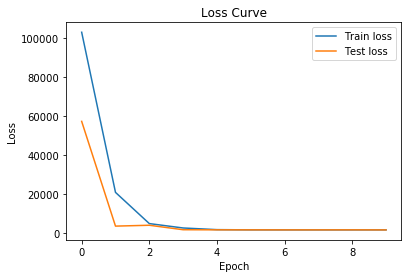

In [96]:
import matplotlib.pyplot as plt
import numpy as np

loss_train = np.array(loss_list)
#loss_test = np.array(loss_test_list)
loss_test = np.array(loss_test_list)
# 绘制训练集和测试集的损失曲线
plt.plot(loss_train, label="Train loss")
plt.plot(loss_test, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.savefig("loss_plot.png", dpi=1000)
plt.show()




In [97]:
model

SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_self): Linear(in_features=15, out_features=300, bias=False)
    (fc_neigh): Linear(in_features=15, out_features=300, bias=False)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_self): Linear(in_features=300, out_features=1, bias=False)
    (fc_neigh): Linear(in_features=300, out_features=1, bias=False)
  )
)

In [98]:
g1_test=test_set[4].to(device)
feat_test=g1_test.ndata['feat'].to(device)
label_test=g1_test.ndata['label'].to(device)

In [99]:
print(g1_test)
print(feat_test)
print(label_test)

Graph(num_nodes=12631, num_edges=79101,
      ndata_schemes={'O_WSPD': Scheme(shape=(1,), dtype=torch.float32), 'CRS_DEP_TIME': Scheme(shape=(1,), dtype=torch.float32), 'DEP_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'CRS_ARR_TIME': Scheme(shape=(1,), dtype=torch.float32), 'WHEELS_OFF': Scheme(shape=(1,), dtype=torch.float32), 'O_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'ARR_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'DEST': Scheme(shape=(1,), dtype=torch.float32), 'ORIGIN': Scheme(shape=(1,), dtype=torch.float32), 'O_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'DISTANCE': Scheme(shape=(1,), dtype=torch.float32), 'O_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'O_PRCP': Scheme(shape=(1,), dtype=torch.float32), 'D_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'D_PRCP': Scheme(shape=(1,), dtype=torch.float32), 'feat': Scheme(shape=(15,), dtyp

In [100]:
test_pred=model(g1_test,feat_test)

In [101]:
test_pred

tensor([[-5.3180],
        [ 0.4129],
        [ 1.0339],
        ...,
        [-3.8799],
        [-3.8799],
        [-3.8799]], device='cuda:0', grad_fn=<AddBackward0>)

In [102]:
label_test

tensor([[-8.],
        [ 4.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')

In [103]:
labels=label_test

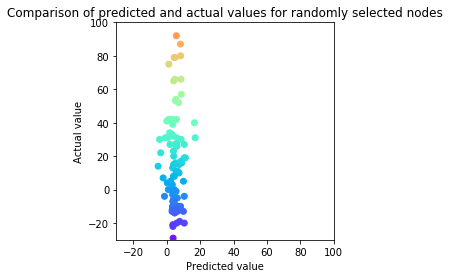

In [107]:
import matplotlib.pyplot as plt
import numpy as np


# 对测试集中的一些节点进行预测和比较
#nodes = [1, 6, 9, 55, 554, 364, 51, 166, 244, 365, 644, 431, 2, 65]
nodes=np.arange(1,100,1)
#nodes=np.arange(1,g1_test.ndata['feat'].shape[0],1)
preds = test_pred[nodes].cpu().detach().numpy()
labels = label_test[nodes].cpu().detach().numpy()
plt.scatter(preds, labels, c=labels, cmap='rainbow')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Comparison of predicted and actual values for randomly selected nodes')
plt.xlim(-30,100)
plt.ylim(-30,100)
ax = plt.gca()
ax.set_aspect(1)#横纵坐标比例

plt.show()